In [1]:
"""
    Import all the important required Deep Learning Libraries to train the emotions model.
    
    Keras is an Application Programming Interface (API) which can run on top of tensorflow.
    
    tensorflow will be the main deep learning module we will use to build our deep learning model.
    
    The ImageDataGenerator is used for Data augmentation where the model can see more copies of 
        the model. Data Augmentation is used for creating replications of the original images 
        and using those transformations in each epoch.
        
    The layers for training which will be used are as follows:
    1. Input = The input layer which we pass the input shape.
    2. Conv2D = The Convoluional layer combined with Input to provide a output of tensors
    3. Maxpool2D = Downsampling the Data from the convolutional layer.
    4. Batch normalization = It is a technique for training very deep neural networks that standardizes 
       the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning 
       process and dramatically reducing the number of training epochs required to train deep networks.
    5. Dropout = Dropout is a technique where randomly selected neurons are ignored during training. 
                 They are “dropped-out” randomly and this prevents over-fitting.
    6. Dense = Fully Connected layers.
    7. Flatten = Flatten the entire structure to a 1-D array.
    
    The Models can be built in a model like structure as shown in this particular model or can be built 
        in a sequential manner.
        
    Use of l2 regularization for fine tuning.
    
    The optimizer used will be Adam as it is performs better than the other optimizers on this model.
    
    Numpy for numerical array like operations.
    
    pydot_ng and graphviz are used for making plots.
    
    We are also importing the os module to make it compatible with the windows environment. 
    
"""

import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pydot_ng
import graphviz
import os

Using TensorFlow backend.


In [2]:
"""
    num_classes = Defines the number of classes we have to predict which are namely 
    Angry, Fear, Happy, Neutral, Surprise, Neutral and Disgust.
    
    From the exploratory Data Analysis we know that The Dimensions of the image are:
    Image Height = 48 pixels
    Image Width = 48 pixels
    Number of channels = 1 because it is a grayscale image.
    
    We will consider a batch size for the training of the image augmentation.

"""

num_classes = 7
batch_size = 64
epochs = 100
Img_height = 48
Img_width = 48

In [3]:
"""
    Store the csv file in data and then print the first 5 rows.

"""

data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
"""
    Reference: https://github.com/oarriaga/face_classification
    We will convert the pixels to list in this method. 
    We split the data by spaces and then take them as arrays and 
    reshape into 48, 48 shape. Then we expand the dimensions 
    and then convert the labels to categorical matrix.

"""

pixels = data['pixels'].tolist() 
faces = []

for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(Img_height, Img_width) 
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

emotions = pd.get_dummies(data['emotion']).values

### Splitting of data:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

### Emotions Model:

In [6]:
"""
    We will be using a sequential type architecture for our model.
    Our Sequential model will have a total of 5 blocks i.e. three
    convolutional blocks, one fully connected layer and one output
    layer.
    
    We will have 3 Convolutional Blocks with filters of increasing size
    as 32, 64 and 128 respectively. The kernel_size will be (3,3) and
    the kernel_initializer will be he_normal. We can also use a 
    kernel_regularizer with l2 normalization. Our Preferred choice of 
    activation is relu because it usually performs better on most datasets.
    The Input shape will be the same as the size of each of our train and
    validation images.
    The BatchNormalization layer Batch normalization is a technique for improving 
    the speed, performance, and stability of artificial neural networks.
    and Maxpooling is used to Downsample the data. 
    The Dropout layer is used for prevention of overfitting.
    
    The fully connected block consists of a Dense layer of 64 filters
    and a batch normalization followed by a dropout layer. Before passing
    through the Dense layer the data is flattened to match the dimensions.
    
    Finally the output layer consists of a Dense layer with a softmax
    activation to give probabilites according to the num_classes which
    represents the number of predictions to be made. 

"""


model = Sequential()

# Block-1: The First Convolutional Block

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", 
                 input_shape=(Img_height, Img_width, 1), 
                 name="Conv1"))

model.add(BatchNormalization(name="Batch_Norm1"))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv2"))

model.add(BatchNormalization(name="Batch_Norm2"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool1"))
model.add(Dropout(0.5, name="Dropout1"))

# Block-2: The Second Convolutional Block

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", name="Conv3"))

model.add(BatchNormalization(name="Batch_Norm3"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv4"))

model.add(BatchNormalization(name="Batch_Norm4"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool2"))
model.add(Dropout(0.5, name="Dropout2"))

# Block-3: The Third Convolutional Block

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv5"))

model.add(BatchNormalization(name="Batch_Norm5"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", name="Conv6"))

model.add(BatchNormalization(name="Batch_Norm6"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool3"))
model.add(Dropout(0.5, name="Dropout3"))

# Block-4: The Fully Connected Block

model.add(Flatten(name="Flatten"))
model.add(Dense(64, activation="relu", kernel_initializer='he_normal', name="Dense"))
model.add(BatchNormalization(name="Batch_Norm7"))
model.add(Dropout(0.5, name="Dropout4"))

# Block-5: The Output Block

model.add(Dense(num_classes, activation="softmax", kernel_initializer='he_normal', name = "Output"))

### Model Summary: 

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 48, 48, 32)        320       
_________________________________________________________________
Batch_Norm1 (BatchNormalizat (None, 48, 48, 32)        128       
_________________________________________________________________
Conv2 (Conv2D)               (None, 48, 48, 32)        9248      
_________________________________________________________________
Batch_Norm2 (BatchNormalizat (None, 48, 48, 32)        128       
_________________________________________________________________
Maxpool1 (MaxPooling2D)      (None, 24, 24, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 24, 24, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 24, 64)        1

### Model Plot:

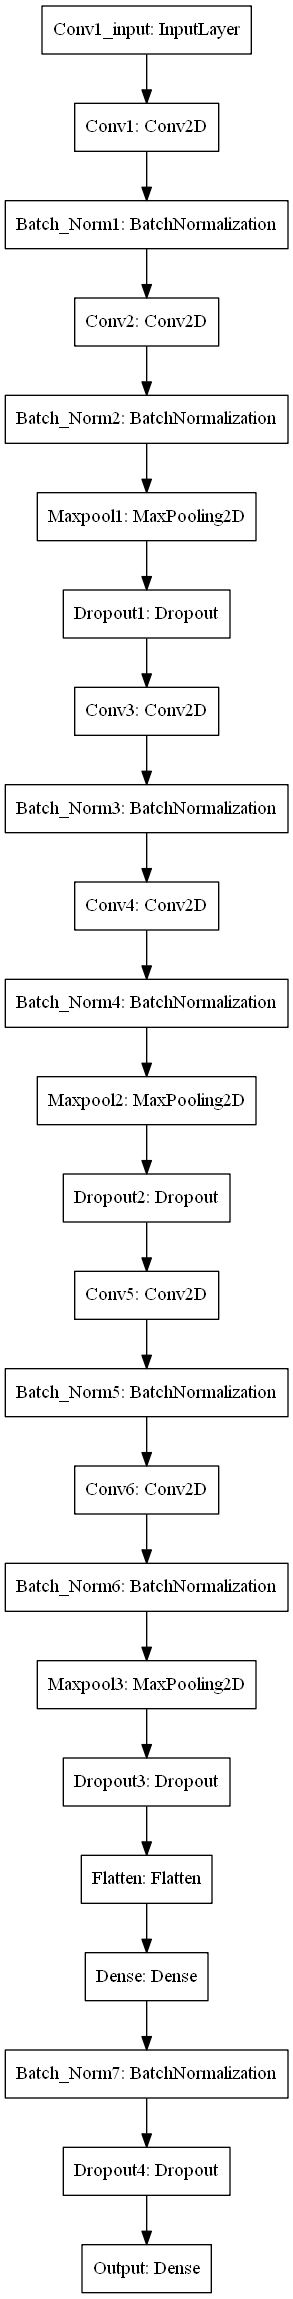

In [8]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model, to_file='model3.png', show_layer_names=True)

### Compile the Model:

In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

### Callbacks:

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

tensorboard = TensorBoard(log_dir='logs3')
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("emotions3.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

### Fit the Model:

In [11]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Train on 29068 samples, validate on 3589 samples
Epoch 1/100
29056/29068 [============================>.] - ETA: 0s - loss: 1.9944 - accuracy: 0.2740
Epoch 00001: val_accuracy improved from -inf to 0.37726, saving model to emotions3.h5
29068/29068 [==============================] - 16s 556us/sample - loss: 1.9944 - accuracy: 0.2741 - val_loss: 1.6024 - val_accuracy: 0.3773
Epoch 2/100
29056/29068 [============================>.] - ETA: 0s - loss: 1.6250 - accuracy: 0.3770
Epoch 00002: val_accuracy improved from 0.37726 to 0.43996, saving model to emotions3.h5
29068/29068 [==============================] - 10s 359us/sample - loss: 1.6249 - accuracy: 0.3771 - val_loss: 1.4691 - val_accuracy: 0.4400
Epoch 3/100
29056/29068 [============================>.] - ETA: 0s - loss: 1.4935 - accuracy: 0.4281
Epoch 00003: val_accuracy improved from 0.43996 to 0.47311, saving model to emotions3.h5
29068/29068 [==============================] - 10s 353us/sample - loss: 1.4936 - accuracy: 0.4280 - val_

Epoch 26/100
29056/29068 [============================>.] - ETA: 0s - loss: 0.9582 - accuracy: 0.6444
Epoch 00026: val_accuracy improved from 0.63109 to 0.63500, saving model to emotions3.h5
29068/29068 [==============================] - 10s 359us/sample - loss: 0.9583 - accuracy: 0.6443 - val_loss: 0.9892 - val_accuracy: 0.6350
Epoch 27/100
29056/29068 [============================>.] - ETA: 0s - loss: 0.9532 - accuracy: 0.6448
Epoch 00027: val_accuracy did not improve from 0.63500
29068/29068 [==============================] - 10s 356us/sample - loss: 0.9531 - accuracy: 0.6448 - val_loss: 0.9881 - val_accuracy: 0.6294
Epoch 28/100
29056/29068 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.6533
Epoch 00028: val_accuracy did not improve from 0.63500
29068/29068 [==============================] - 10s 356us/sample - loss: 0.9382 - accuracy: 0.6534 - val_loss: 1.0326 - val_accuracy: 0.6119
Epoch 29/100
29056/29068 [============================>.] - ETA: 0s - loss:

### Graph:

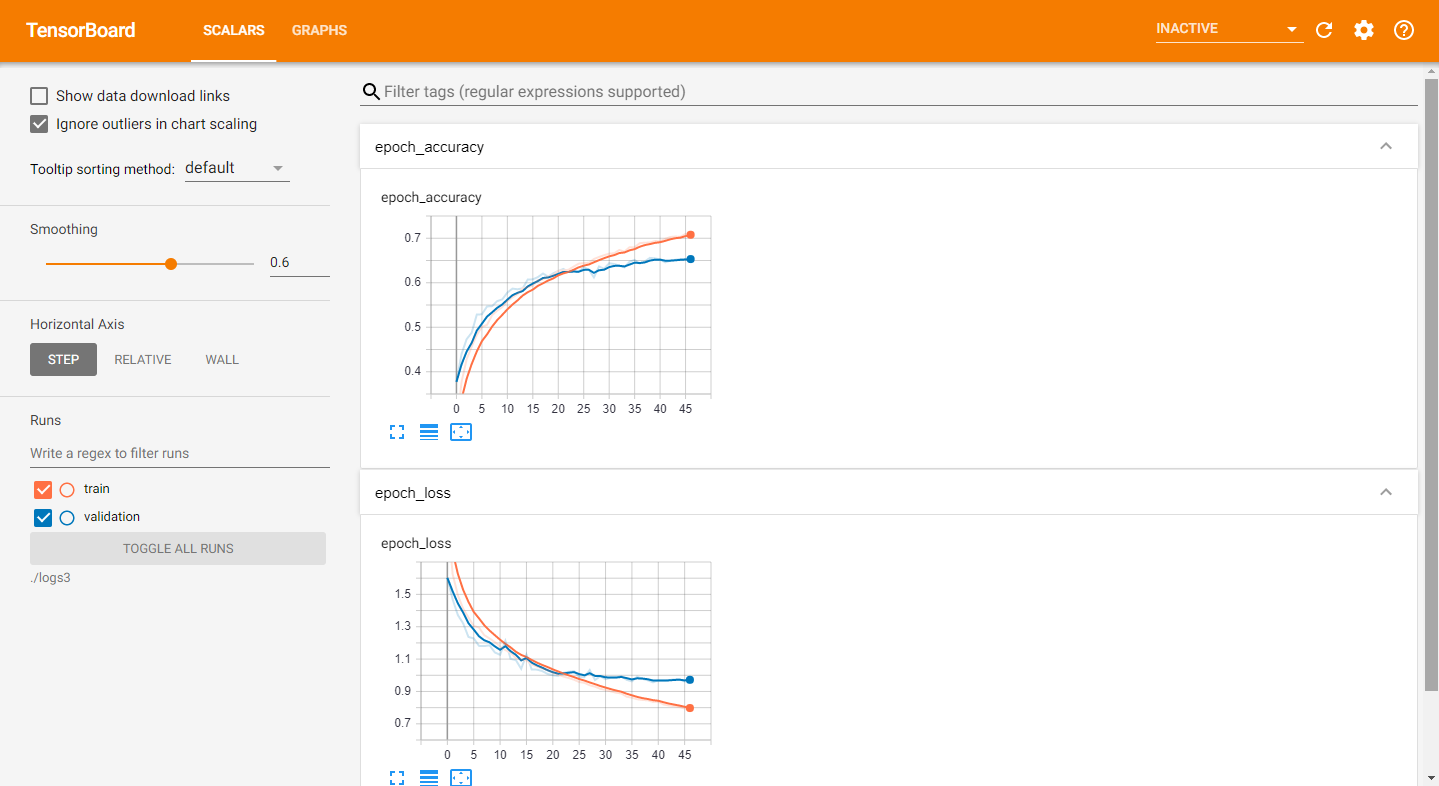

In [12]:
"""
    To access the logs and graphs type the below command in the
    command prompt :
    tensorboard --logdir="./logs3"
    
    Copy the URL link given and go the location to see the graphs
    via the local system.
    
    Below is a screenshot of the the graphs from Tensorboard.

"""

from IPython.display import Image 

pil_img = Image(filename='finalGraph.png')
display(pil_img)

### The Model is able to perform quite well. We can notice that the train and validation losses are decreasing constantly and the train as well as validation accuracy increases constantly. There is no overfitting in the deep learning model and we are able to achieve an validation accuracy of over 65% and an accuracy of almost 70% and reduce the loss as well.